#### OBJ:
* run simple regression
* boostrap regression model for uncertainty
* compare with standard analytical 95% CIs


Idea based on "The art of statistics" - David Spiegelhalter, Chapter 7

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
X, y = make_classification(n_samples = 1000, n_features = 2, n_redundant=0, class_sep=0.1,
                           n_clusters_per_class=1, random_state=77,
                          weights={0:0.85, 1:0.15})

In [107]:
y.shape

(1000,)

In [108]:
X.shape

(1000, 2)

In [109]:
df = pd.DataFrame(data = X, columns= ['X1','X2'])

In [110]:
df['y'] = y

In [111]:
df.head(3)

,X1,X2,y
0,0.298220,-0.220733,0
1,0.060015,0.240946,0
2,0.263238,-0.709299,0


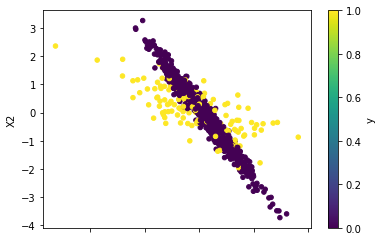

In [112]:
df.plot(x = 'X1', y = 'X2',c = 'y',colormap='viridis', kind='scatter')

#### model

In [113]:
from sklearn.linear_model import LogisticRegression

In [114]:
model = LogisticRegression()

In [115]:
# X = df['X1'].values.reshape(-1, 1)
X = df[['X1','X2']]
y = df['y']
# y = df['y'].values.reshape(-1, 1)

In [116]:
model.fit(X, y)

C:\Anaconda3\envs\EDclass\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
from src.eval.eval_utils import ModelCVEvaluation

C:\Anaconda3\envs\EDclass\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\EDclass\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
No handles with labels found to put in legend.
C:\Anaconda3\envs\EDclass\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


INPUT DATA
FEATURES:2
TRAINING SAMPLES: 1000
CLASS 1 PROPORTION: 0.16
CV RESULTS
average_precision
TRAIN MEAN (std):  0.485 ( 0.014 )
VALID MEAN (std):  0.432 ( 0.002 )
DIFF BETWEEN MEAN:  0.053
briers_score_loss
TRAIN MEAN (std):  0.133 ( 0.004 )
VALID MEAN (std):  0.117 ( 0.010 )
DIFF BETWEEN MEAN:  0.016


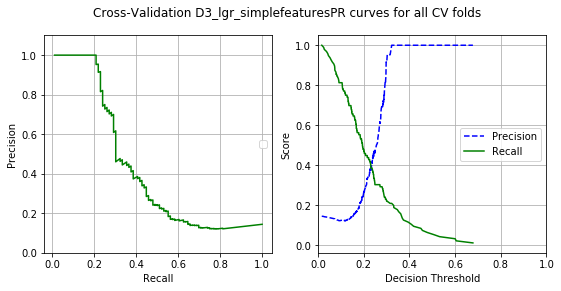

In [118]:
meval = ModelCVEvaluation(model, 'D3_lgr_simplefeatures', X, y, 2)

### Max briers score

In [119]:
prop = 0.15
prop * (1-prop)**2 + (1-prop)*prop**2

0.12749999999999997

#### plot results

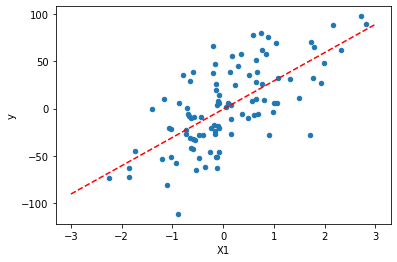

In [14]:
fig, ax = plt.subplots()

df.plot('X1','y', kind='scatter',ax=ax) # scatter

# make points
x1 = -3
x2 = 3
y1 = float(coef_x * x1 + intercept)
y2 = float(coef_x * x2 + intercept)
xline = [x1, x2]
yline = [y1, y2]

ax.plot(xline, yline, 'r--')

#### Bootstrap coef

Create sample of data

In [15]:
def choose_random_index(array_size):
    "Choose random integer index between 0 and size-1. Size is int for length of array sampling over."
    index = np.random.randint(0, array_size-1)
    return(index)

def get_bootstrap_sample(X, y, sample_size):
    """
    Produce a bootstrap sample from exisiting X, y arrays. Currently only works for single feature arrays.
    Input
    =====
    X, array, features
    y, array, labels
    
    Return
    ======
    Xs, list of floats, X values for sample
    ys, list of floats, y values for sample
    """
    
    Xs = []
    ys = []
    
    for i in np.arange(sample_size): # loop through, take a sample each time and append to X and y lists.
        index = choose_random_index(len(X))
        Xs.append(X[index])
        ys.append(y[index])
    
    return(Xs,ys)

# X_boot, y_boot = get_bootstrap_sample(X, y, 10)

In [16]:
coefs = []
intercepts = []

for i in np.arange(0,999): # number of bootstraps
    X_boot, y_boot = get_bootstrap_sample(X, y, 100) # this input is the size of the sample
    ols.fit(X_boot, y_boot)
    coefs.append(ols.coef_[0][0])
    intercepts.append(ols.intercept_[0])

In [17]:
pd.DataFrame(coefs).describe()

,0
count,5999.000000
mean,30.190429
std,2.853436
min,18.545211
25%,28.330614
50%,30.303112
75%,32.054572
max,43.224222


In [18]:
pd.DataFrame(coefs).quantile(0.975)

0    35.681364
Name: 0.975, dtype: float64

In [19]:
pd.DataFrame(coefs).quantile(0.025)

0    24.487247
Name: 0.025, dtype: float64

The size of bootstrap samples affects the quantiles produced. Just as in the book.

#### ols with statsmodels

In [20]:
import statsmodels.api as sm

C:\Anaconda3\envs\ml\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
results = model.fit()
results.params

array([-0.59325773, 29.84090281])

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     83.41
Date:                Tue, 03 Sep 2019   Prob (F-statistic):           9.22e-15
Time:                        13:52:04   Log-Likelihood:                -488.29
No. Observations:                 100   AIC:                             980.6
Df Residuals:                      98   BIC:                             985.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5933      3.240     -0.183      0.855      -7.024       5.837
x1            29.8409      3.267      9.133      0.000      23.357      36.325
==============================================================================
Omnibus:                        0.159   Durbin-Watson:                   2.225
Prob(Omnibus):                  0.924   Jarque-Bera (JB):                0.342
Skew:                           0.003   Prob(JB):                        0.843
Kurtosis:                       2.713   Cond. No.                         1.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The bootstrap samples find a smaller interval than the CI found using statsmodels.

Further questions:
* what is the difference between these estimates? are bootstraps only estimating a certain type of error in comparison to CIs?
* what is the difference between doing these estimates on CV/Test sets?